In [1]:
from matplotlib import pyplot as plt
import matplotlib.colors as colors

import numpy as np
import xarray as xr
import pandas as pd
from xgcm import Grid
import dask.array as da

from definition.defPrincipal import *

%matplotlib inline

In [2]:
from dask.distributed import Client, LocalCluster
#
# Initialisation d'un cluster de 32 coeurs
cluster = LocalCluster(processes=False, n_workers=1, threads_per_worker=6)
client = Client(cluster)
client

Client Scheduler: inproc://134.246.213.244/23506/1 Dashboard: http://134.246.213.244:8787/status,Cluster Workers: 1 Cores: 6 Memory: 33.67 GB


In [3]:
def _adjust_grid(ds):
        # relevant to regular/analytical grid for now
        #
        ds = ds.reset_coords([c for c in ds.coords if 'nav' in c])
        
        # rename redundant dimensions
        _dims = (d for d in ['x_v', 'y_u', 'x_w', 'y_w'] if d in ds.dims)
        for d in _dims:
            ds = ds.rename({d: d[0]+'_rho'})
                
        # change nav variables to coordinates        
        _coords = [d for d in [d for d in ds.data_vars.keys()] if "nav_" in d]
        ds = ds.set_coords(_coords) 
        
        # rename coordinates 
        eta_suff={}
        for c in ds.coords:
            new_c = c.replace('nav_lat','eta').replace('nav_lon','xi')
            ds = ds.rename({c:new_c})
            # reset names and units
            ds[new_c] = (ds[new_c].assign_attrs(units='m', 
                                               standard_name=new_c,
                                               long_name=new_c)
                        )
        # Create xgcm grid
        coords={'xi':{'center':'x_rho', 'inner':'x_u'}, 
                'eta':{'center':'y_rho', 'inner':'y_v'}, 
                's':{'center':'s_rho', 'outer':'s_w'}}
        ds.attrs['xgcm-Grid'] = Grid(ds, coords=coords)
        
        return ds

In [4]:
zarr_dir = '/media/durand/Gigatl/data_juill/zarr_dir_snap/217/'
#V = ds.data_vars
V = ['zeta', 'u', 'v','rho']
datasets = []
for v in V:
    ds = xr.open_zarr(zarr_dir+'%s.zarr'%(v))
    datasets.append(ds)
ds = xr.merge(datasets)
ds

<xarray.Dataset>
Dimensions:       (s_rho: 50, x_rho: 1502, x_u: 1501, x_v: 1502, y_rho: 2002, y_u: 2002, y_v: 2001)
Coordinates:
    nav_lat_rho   (y_rho, x_rho) float32 dask.array<chunksize=(501, 376), meta=np.ndarray>
    nav_lon_rho   (y_rho, x_rho) float32 dask.array<chunksize=(501, 376), meta=np.ndarray>
    time_counter  datetime64[ns] 2014-07-15
    time_instant  datetime64[ns] 2014-07-15
    nav_lat_u     (y_u, x_u) float32 dask.array<chunksize=(501, 376), meta=np.ndarray>
    nav_lon_u     (y_u, x_u) float32 dask.array<chunksize=(501, 376), meta=np.ndarray>
  * s_rho         (s_rho) float32 -0.99 -0.97 -0.95 -0.93 ... -0.05 -0.03 -0.01
    nav_lat_v     (y_v, x_v) float32 dask.array<chunksize=(501, 376), meta=np.ndarray>
    nav_lon_v     (y_v, x_v) float32 dask.array<chunksize=(501, 376), meta=np.ndarray>
Dimensions without coordinates: x_rho, x_u, x_v, y_rho, y_u, y_v
Data variables:
    zeta          (y_rho, x_rho) float32 dask.array<chunksize=(501, 376), meta=np.ndarray>
    u             (s_rho, y_u, x_u) float32 dask.array<chunksize=(7, 251, 376), meta=np.ndarray>
    v             (s_rho, y_v, x_v) float32 dask.array<chunksize=(7, 251, 376), meta=np.ndarray>
    rho           (s_rho, y_rho, x_rho) float32 dask.array<chunksize=(7, 251, 376), meta=np.ndarray>

In [5]:
# On ajoute dans le dataset les paramètres de grille qui sont dans le 1ier fichier
path="/media/durand/Gigatl/data/"
gridname = path+'GIGATL6_12h_inst_2004-01-15-2004-01-19.nc'
gd = xr.open_dataset(gridname, chunks={'s_rho': 1})
ds['hc'] = gd.hc
ds['h'] = gd.h
ds['Vtransform'] = gd.Vtransform
ds['sc_r'] = gd.sc_r
ds['sc_w'] = gd.sc_w
ds['Cs_r'] = gd.Cs_r
ds['Cs_w'] = gd.Cs_w
ds['angle'] = gd.angle
ds['mask_rho'] = gd.mask_rho

In [6]:
# On modifie des dimensions et des coordonnées, on crée la grille xgcm
ds = _adjust_grid(ds)
L = ds.dims['x_rho']
M = ds.dims['y_rho']
N = ds.dims['s_rho']
#ds = ds.chunk({'s_rho': 1, 's_w':1, 'x_rho':1000, 'x_u':1000, 'y_rho':1000, 'y_v':1000})
#ds = ds.chunk({'s_rho': 1, 's_w':1, 'x_rho':1, 'x_u':1})
ds

<xarray.Dataset>
Dimensions:       (s_rho: 50, s_w: 51, x_rho: 1502, x_u: 1501, y_rho: 2002, y_v: 2001)
Coordinates:
    eta_rho       (y_rho, x_rho) float32 dask.array<chunksize=(501, 376), meta=np.ndarray>
    xi_rho        (y_rho, x_rho) float32 dask.array<chunksize=(501, 376), meta=np.ndarray>
    time_counter  datetime64[ns] 2014-07-15
    time_instant  datetime64[ns] 2014-07-15
    eta_u         (y_rho, x_u) float32 dask.array<chunksize=(501, 376), meta=np.ndarray>
    xi_u          (y_rho, x_u) float32 dask.array<chunksize=(501, 376), meta=np.ndarray>
  * s_rho         (s_rho) float32 -0.99 -0.97 -0.95 -0.93 ... -0.05 -0.03 -0.01
    eta_v         (y_v, x_rho) float32 dask.array<chunksize=(501, 376), meta=np.ndarray>
    xi_v          (y_v, x_rho) float32 dask.array<chunksize=(501, 376), meta=np.ndarray>
  * s_w           (s_w) float32 -1.0 -0.98 -0.96 -0.94 ... -0.06 -0.04 -0.02 0.0
Dimensions without coordinates: x_rho, x_u, y_rho, y_v
Data variables:
    zeta          (y_rho, x_rho) float32 dask.array<chunksize=(501, 376), meta=np.ndarray>
    u             (s_rho, y_rho, x_u) float32 dask.array<chunksize=(7, 251, 376), meta=np.ndarray>
    v             (s_rho, y_v, x_rho) float32 dask.array<chunksize=(7, 251, 376), meta=np.ndarray>
    rho           (s_rho, y_rho, x_rho) float32 dask.array<chunksize=(7, 251, 376), meta=np.ndarray>
    hc            float32 ...
    h             (y_rho, x_rho) float32 dask.array<chunksize=(2002, 1502), meta=np.ndarray>
    Vtransform    float32 ...
    sc_r          (s_rho) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    sc_w          (s_w) float32 dask.array<chunksize=(51,), meta=np.ndarray>
    Cs_r          (s_rho) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    Cs_w          (s_w) float32 dask.array<chunksize=(51,), meta=np.ndarray>
    angle         (y_rho, x_rho) float32 dask.array<chunksize=(2002, 1502), meta=np.ndarray>
    mask_rho      (y_rho, x_rho) float32 dask.array<chunksize=(2002, 1502), meta=np.ndarray>
Attributes:
    xgcm-Grid:  <xgcm.Grid>\nxi Axis (periodic):\n  * center   x_rho --> inne...

In [7]:
# On crée la grille xgcm
ds = xgcm_grid(ds)
grid = ds.attrs['xgcm-Grid']

In [8]:
%%time
# Compute depth at rho point
z = get_z(ds,zeta=ds['zeta'],hgrid='r').compute()

/home/durand/anaconda3/envs/croco/lib/python3.7/site-packages/dask/array/core.py:3908: PerformanceWarning: Increasing number of chunks by factor of 16
  **blockwise_kwargs,
/home/durand/croco/progForPaper/Part_1/definition/defPrincipal.py:138: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  z = z.transpose(*(zdim,)+_zeta.dims)


CPU times: user 6.06 s, sys: 810 ms, total: 6.87 s
Wall time: 3.11 s


In [9]:
%%time
# get u at rho point
[urot,vrot] = rotuv(ds)
u=urot.compute()


elaps is : 0.4723864739999044
elaps is : 0.5376561570001286
CPU times: user 15.2 s, sys: 1.2 s, total: 16.4 s
Wall time: 10.6 s


In [10]:
rho=ds.rho+1027.4-1000
rho=rho.compute()

[-6. -5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.  6.  7.]


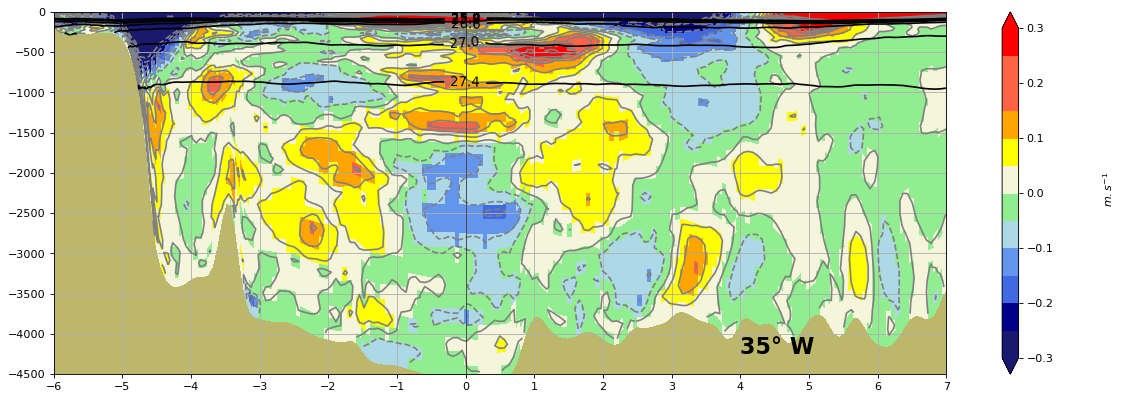

CPU times: user 544 ms, sys: 2.54 ms, total: 546 ms
Wall time: 530 ms


In [12]:
%%time

longitude = -35.
vnew= slice(ds,u,z,longitude=longitude)
vnew2= slice(ds,rho,z,longitude=longitude)
plt.figure(figsize=(8,6), dpi=80)

cmap = colors.ListedColormap(['black', 'midnightblue','darkblue', 'royalblue','cornflowerblue','lightblue', 'lightgreen', 'beige', 'yellow', 'orange','tomato','tomato','red'])
boundaries = np.linspace(-0.3, 0.3, 13)
norm = colors.BoundaryNorm(boundaries, cmap.N, clip=True)

vnew.plot(x=[s for s in vnew.coords if s in ["eta_rho","eta_u","eta_v"]][0],
          y=[s for s in vnew.coords if "z" in s][0],
          xlim=[-6.,7.], 
          ylim=[-4500.,0.],
          #vmin=0.,
          cmap=cmap, norm=norm
         )

vnew.plot.contour(x=[s for s in vnew.coords if s in ["eta_rho","eta_u","eta_v"]][0],
          y=[s for s in vnew.coords if "z" in s][0],levels=boundaries,colors='grey')


contour=vnew2.plot.contour(x=[s for s in vnew.coords if s in ["eta_rho","eta_u","eta_v"]][0],
          y=[s for s in vnew.coords if "z" in s][0],levels=np.linspace(25,27.4,7),colors='black')

manual_locations = [(0, -1.4), (0, -0.7), (0, -100), (0, -200), (0., -500), (0., -1000.)]

plt.clabel(contour, fontsize=12,fmt = '%2.1f',inline=True,manual=manual_locations)
ax = plt.gca()
ax.set_facecolor('darkkhaki')

axisx=np.linspace(-6, 7, 14)
print(axisx)
ax.xaxis.set_ticks(axisx)
plt.axvline(x=-0.,color='black',linewidth=0.5)
plt.grid()
plt.text(4., -4250, '35° W',fontweight = 'bold', fontsize = 20)
plt.text(9.25, -2400, '$m.s^{-1}$', fontsize = 10, rotation='vertical')

plt.title("")
plt.xlabel("")
plt.ylabel("")

plt.show()


[-6. -5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.  6.  7.]


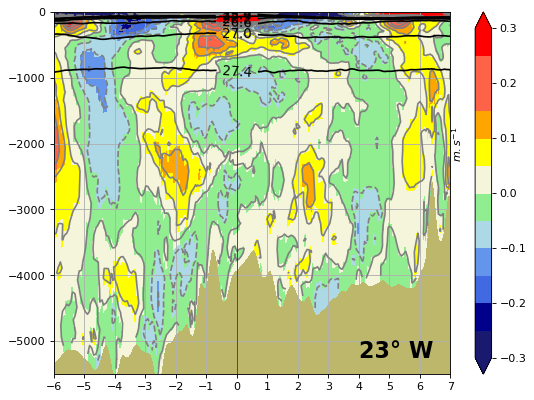

In [29]:
longitude = -23.
vnew= slice(ds,u,z,longitude=longitude)
vnew2= slice(ds,rho,z,longitude=longitude)
plt.figure(figsize=(8,6), dpi=80)

cmap = colors.ListedColormap(['black', 'midnightblue','darkblue', 'royalblue','cornflowerblue','lightblue', 'lightgreen', 'beige', 'yellow', 'orange','tomato','tomato','red'])
boundaries = np.linspace(-0.3, 0.3, 13)
norm = colors.BoundaryNorm(boundaries, cmap.N, clip=True)

vnew.plot(x=[s for s in vnew.coords if s in ["eta_rho","eta_u","eta_v"]][0],
          y=[s for s in vnew.coords if "z" in s][0],
          xlim=[-6.,7.], 
          ylim=[-5500.,0.],
          #vmin=0.,
          cmap=cmap, norm=norm
         )


vnew.plot.contour(x=[s for s in vnew.coords if s in ["eta_rho","eta_u","eta_v"]][0],
          y=[s for s in vnew.coords if "z" in s][0],levels=boundaries,colors='grey')

contour=vnew2.plot.contour(x=[s for s in vnew.coords if s in ["eta_rho","eta_u","eta_v"]][0],
          y=[s for s in vnew.coords if "z" in s][0],levels=np.linspace(25,27.4,7),colors='black')

manual_locations = [(0, -1.4), (0, -0.7), (0, -100), (0, -200), (0., -500), (0., -1000.)]

plt.clabel(contour, fontsize=12,fmt = '%2.1f',inline=True,manual=manual_locations)
ax = plt.gca()
ax.set_facecolor('darkkhaki')

axisx=np.linspace(-6, 7, 14)
print(axisx)
ax.xaxis.set_ticks(axisx)
plt.axvline(x=-0.,color='black',linewidth=0.5)
plt.grid()
plt.text(4., -5250, '23° W',fontweight = 'bold', fontsize = 20)
plt.text(7, -2250, '$m.s^{-1}$', fontsize = 10, rotation='vertical')

plt.title("")
plt.xlabel("")
plt.ylabel("")
plt.show()

[-6. -5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.]


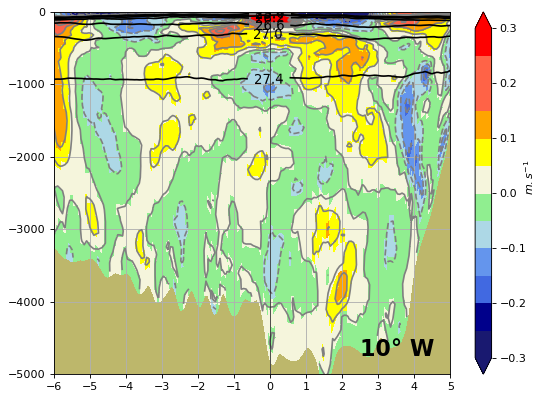

In [28]:
longitude = -10.
vnew= slice(ds,u,z,longitude=longitude)
vnew2= slice(ds,rho,z,longitude=longitude)
plt.figure(figsize=(8,6), dpi=80)

cmap = colors.ListedColormap(['black', 'midnightblue','darkblue', 'royalblue','cornflowerblue','lightblue', 'lightgreen', 'beige', 'yellow', 'orange','tomato','tomato','red'])
boundaries = np.linspace(-0.3, 0.3, 13)
norm = colors.BoundaryNorm(boundaries, cmap.N, clip=True)

vnew.plot(x=[s for s in vnew.coords if s in ["eta_rho","eta_u","eta_v"]][0],
          y=[s for s in vnew.coords if "z" in s][0],
          xlim=[-6.,5.], 
          ylim=[-5000.,0.],
          #vmin=0.,
          cmap=cmap, norm=norm
         )

vnew.plot.contour(x=[s for s in vnew.coords if s in ["eta_rho","eta_u","eta_v"]][0],
          y=[s for s in vnew.coords if "z" in s][0],levels=boundaries,colors='grey')

contour=vnew2.plot.contour(x=[s for s in vnew.coords if s in ["eta_rho","eta_u","eta_v"]][0],
          y=[s for s in vnew.coords if "z" in s][0],levels=np.linspace(25,27.4,7),colors='black')

manual_locations = [(0, -1.4), (0, -0.7), (0, -100), (0, -200), (0., -500), (0., -1000.)]

plt.clabel(contour, fontsize=12,fmt = '%2.1f',inline=True,manual=manual_locations)
ax = plt.gca()
ax.set_facecolor('darkkhaki')

axisx=np.linspace(-6, 5, 12)
print(axisx)
ax.xaxis.set_ticks(axisx)
plt.axvline(x=-0.,color='black',linewidth=0.5)
plt.grid()
plt.title("")
plt.xlabel("")
plt.ylabel("")
plt.text(2.5, -4750, '10° W',fontweight = 'bold', fontsize = 20)
plt.text(7, -2500, '$m.s^{-1}$', fontsize = 10, rotation='vertical')
plt.show()

In [14]:
# cluster.close()